## 8. マルコフ連鎖モンテカルロ(MCMC)法とベイズ統計モデル
複雑な統計モデルのあてはめる方法として、**マルコフ連鎖モンテカルロ(MCMC)法**がある。  
あるデータに対してMCMCアルゴリズムを適用すると、推定結果はある確率分布からのランダムサンプルとして得られる。   
このような操作をMCMCサンプリング、得られた結果をMCMCサンプルと呼ぶ。  

### 8.1 種子の生存確率
植物20個体について、それぞれ8個ずつの種子の生死を調べたとする。  
ヒストグラムで図示すると、過分散ではにようであるので、生存種子数$y_i$が二項分布に従うと仮定する。  
20個体に共通する生存確率を$q$とすると、ある個体$i$の生存種子数が$y_i$である確率は、
$$
p(y_i|q)=
\begin{pmatrix}
8\\
y_i
\end{pmatrix}
q^{y_i}(1-q)^{8-y_i}
$$
となり、尤度は、
$$
L(q)=p(\boldsymbol{Y}|q)=\prod_ip(y_i|q)
$$
対数尤度は、
$$
\log{L(q)}=\sum_i\{y_i\log{q} + (1-y_i)\log{(1-q)} \}
$$
となる。  
対数尤度の傾きがゼロになる$\hat{q}$をもとめると、データ$\boldsymbol{Y}$のもとでの最尤推定値は以下のようになる。
$$
\hat{q}=\frac{合計生存種子数}{合計調査種子数}=\frac{73}{8×20}=0.45625
$$

max_id


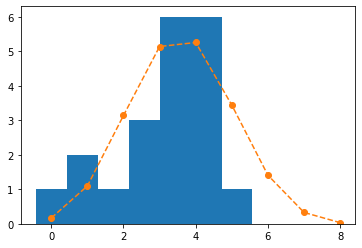

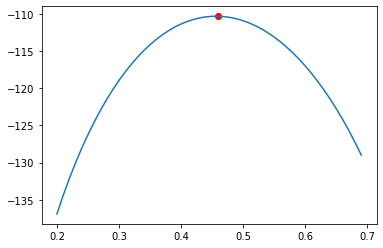

In [167]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

x = np.arange(0,9)
y = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])

p = binom.pmf(k=x, n=8, p=0.45)*len(y)

xx = np.arange(0.2, 0.7, 0.01)

logL = []
for i in xx:
    logL.append(np.sum(y*np.log(i) + (8-y)*np.log(1-i)))
logL = np.array(logL)
    
max_id = np.argmax(logL)
print('max_id')

plt.hist(y, bins=7, align='left');
plt.plot(x, p, '--o');
plt.show()

plt.plot(np.arange(0.2, 0.7, 0.01), logL)
plt.scatter(xx[max_id], logL[max_id], color='red')

### 8.2 ふらふら試行錯誤による最尤推定
最尤推定量$\hat{q}$が解析的に求められない場合、繰り返し試行錯誤によって$q$を少しずつ変化させることで、  
対数尤度が高くなる$\hat{q}$を探し出せる。

### 8.3 MCMCアルゴリズムのひとつ: メトロポリス法
MCMCのメトロポリス法の手順を示す。
1. パラメータ$q$の初期値を選ぶ
2. $q$を増やすか減らすかをランダムに決める(新しく選んだ$q$を$q^{new}$とする)
3. $q^{new}$において尤度が大きくなるならqの値を$q^{new}$に変更する
4. $q^{new}$で尤度が小さくなる場合であっても、確率$r$で$q$の値を$q^{new}$に変更する

このとき悪くなる方向に$q$を変化させる確率$r$が尤度比$r=L(q^{new})/L(q)$に等しいと設定する。  
  
MCMCアルゴリズムでは、ひとつのステップの中で前の状態$q$に基づいて新しい状態$q^{new}$を作り出しているので、**マルコフ連鎖**となっている。  
また、一般に乱数を利用した計算アルゴリズムは**モンテカルロ法**と呼ばれる。

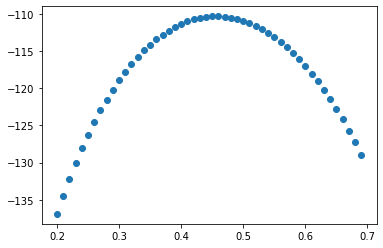

In [169]:
plt.scatter(xx, logL)

In [134]:
xx = np.linspace(0.2, 0.7, 51)

logL = []
for i in xx:
    logL.append(np.sum(y*np.log(i) + (8-y)*np.log(1-i)))
logL = np.array(logL)

def mcmc1(n):
    q = np.random.randint(0, 51)
    Q = [xx[q]]
    for i in range(n):
        # qを増やすか減らすか
        a = np.random.choice([1, -1])
    
        # 新しいq
        q_new = q + a
    
        # 新しいqの尤度によって変更するか決める
        if np.exp(logL[q_new]) >= np.exp(logL[q]):
            q = q_new
        else:
            q = np.random.choice([q, q_new], p =[1-np.exp(logL[q_new]-logL[q]), np.exp(logL[q_new]-logL[q])])
        Q.append(xx[q])
    return Q

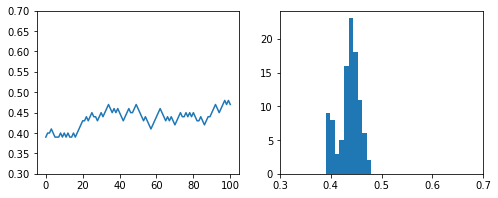

In [151]:
Q = mcmc1(n=100)

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 3))

axes[0].plot(Q);
axes[0].set_ylim([0.3, 0.7]);

axes[1].hist(Q);
axes[1].set_xlim([0.3, 0.7]);

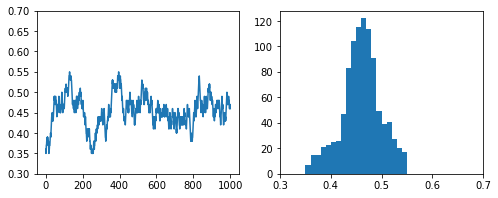

In [165]:
Q = mcmc1(n=1000)

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 3))

axes[0].plot(Q);
axes[0].set_ylim([0.3, 0.7]);

axes[1].hist(Q, bins=20);
axes[1].set_xlim([0.3, 0.7]);

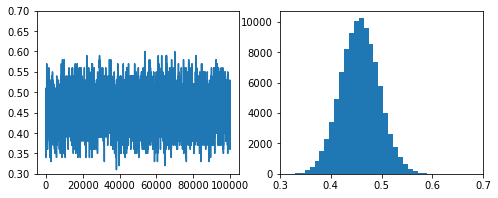

In [161]:
Q = mcmc1(n=100000)

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 3))

axes[0].plot(Q);
axes[0].set_ylim([0.3, 0.7]);

axes[1].hist(Q, bins=30);
axes[1].set_xlim([0.3, 0.7]);

ステップ数が増えると、ヒストグラムの形状がマルコフ連鎖の定常分布に似たものになっていく。

定常分布とは、ある変数$q$のマルコフ連鎖が一定の条件を満たしているときに、  
そのマルコフ連鎖から発生する$q$の値がしたがう確率分である。  
ここでは、定常分布を$p(q|\boldsymbol{Y})$と表記する。

定常分布$p(q|\boldsymbol{Y})$は尤度$L(q)$に比例する確率分布である。  
尤度$L(q)$に比例する離散化した$q$の確率分布とは、
$$
p(q|\boldsymbol{Y})=\frac{L(q)}{\sum_qL(q)}
$$

のように定義される。

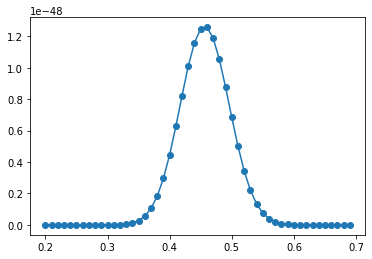

In [172]:
plt.plot(xx, np.exp(logL), '-o');

### 8.4 MCMCサンプリングとベイズ統計モデル
統計モデルのパラメータを確率分布としてあつかう枠組みとして、**ベイズ統計学**が挙げられる。  
ベイズ統計学では、推定したいパラメータは確率分布として表現される。  
ベイズ統計はベイズの公式の形式で推論を行う統計学である。  
ここで、種子の生存確率をベイズの公式の形式で書くと以下のようになる。  
$$
p(q|\boldsymbol{Y})=\frac{p(\boldsymbol{Y}|q)p(q)}{\sum_qp(\boldsymbol{Y}|q)p(q)}
$$

左辺は、データ$\boldsymbol{Y}$が得られたときに$q$が従う確率分布で、**事後分布**と呼ぶ。  
右辺の$p(\boldsymbol{Y}|q)$は、$q$の値が決まっているときにデータ$\boldsymbol{Y}$が観測される確立です。  
今回の場合、$L(q)$がそれに相当するから、$p(\boldsymbol{Y}|q)=L(q)$となる。  
$p(q)$は、データ$\boldsymbol{Y}$がないときの$q$の確率分布で、**事前分布**と呼ぶ。  
右辺の分母は、$p(\boldsymbol{Y})=\sum_qp(\boldsymbol{Y}|q)p(q)$となり、データ$\boldsymbol{Y}$が得られる確率を表す。  
ベイズ統計モデルとは、
$$
事後分布=\frac{尤度×事前分布}{データが得られる確率}\propto 尤度×事前分布
$$

MCMCサンプリングにより定常分布は尤度に比例する確率であると、数値実験的に示された。  
これとベイズの公式を比較すると、事前分布$p(q)$が$q$の値によらず定数になっているとつじつまが合うようになる。